Plots win rate of baseline attacks.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import utils

plt.style.use(
    ["tableau-colorblind10", utils.get_style("default"), utils.get_style("1-col")]
)

In [2]:
edge_x, edge_y, edge_cis, edge_winrate, edge_winrate_cis = (
    np.array([2, 4, 8, 16, 32]),
    np.array([148.75, 125.57, 270.91, 311.96, 311.07]),
    np.array([32.64096667, 31.42023977, 26.51559246, 14.94472483, 16.49799086]),
    np.array([0.51, 0.57, 0.17, 0.01, 0.03]),
    np.array([0.0979804, 0.09703485, 0.07362403, 0.01950175, 0.0334351]),
)
mirror_x, mirror_y, mirror_cis, mirror_winrate, mirror_winrate_cis = (
    np.array([2, 4, 8, 16, 32]),
    np.array([207.19, 239.88709677, 256.18041237, 276.08646617, 253.62]),
    np.array([25.79337205, 16.40883013, 21.08132841, 12.34433871, 22.5459692]),
    np.array([0.09, 0.05069124, 0.04123711, 0.03007519, 0.04]),
    np.array([0.05609163, 0.02918747, 0.03957035, 0.02052525, 0.038408]),
)
spiral_x, spiral_y, spiral_cis, spiral_winrate, spiral_winrate_cis = (
    np.array([2, 4, 8, 16, 32]),
    np.array([304.79, 291.67, 323.21, 323.89, 323.67]),
    np.array([17.63109707, 22.33512761, 11.17424501, 10.9122512, 9.67025367]),
    np.array([0.06, 0.11, 0.0, 0.0, 0.0]),
    np.array([0.04654742, 0.06132639, 0.0, 0.0, 0.0]),
)

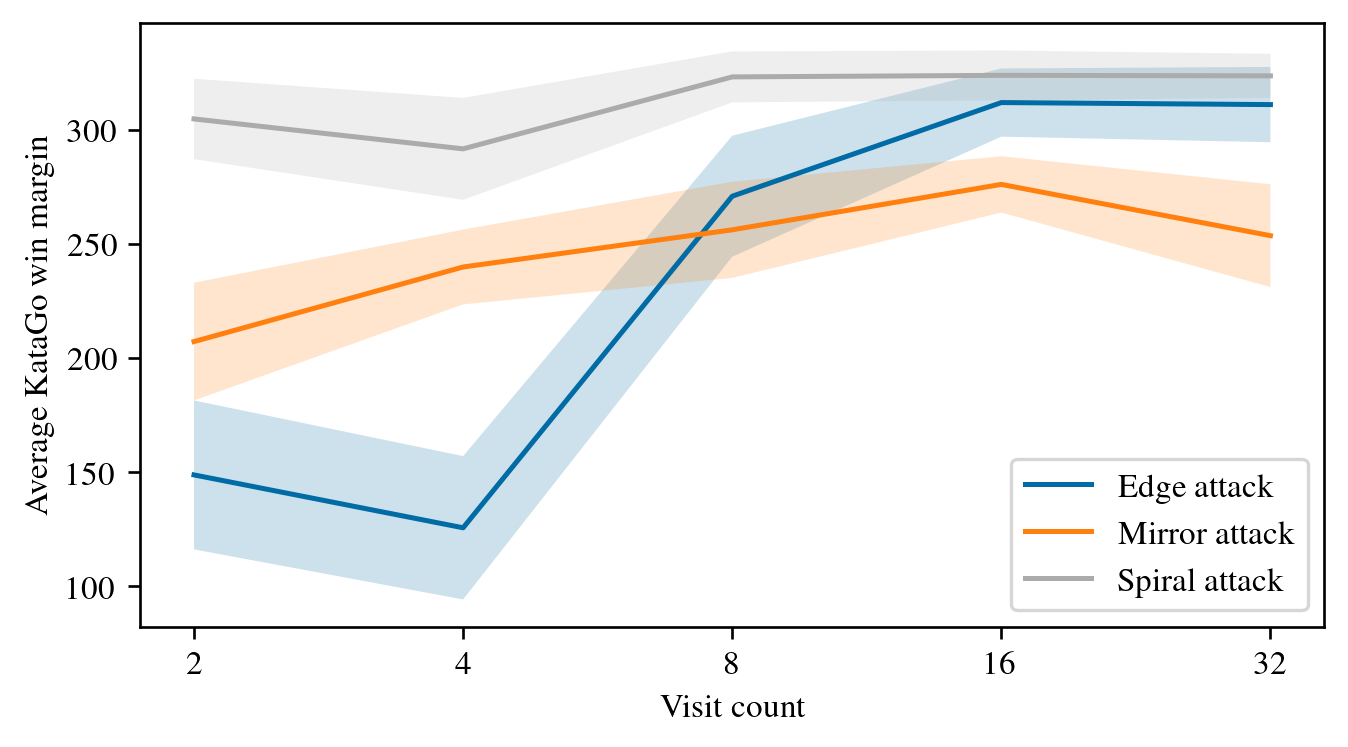

In [4]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Visit count")
ax.set_xscale("log", base=2)
ax.set_ylabel("Average KataGo win margin")
ax.set_xticks(ticks=edge_x, labels=edge_x)
ax.plot(edge_x, edge_y, label="Edge attack")
ax.plot(mirror_x, mirror_y, label="Mirror attack")
ax.plot(spiral_x, spiral_y, label="Spiral attack")
ax.fill_between(edge_x, edge_y - edge_cis, edge_y + edge_cis, alpha=0.2)
ax.fill_between(mirror_x, mirror_y - mirror_cis, mirror_y + mirror_cis, alpha=0.2)
ax.fill_between(spiral_x, spiral_y - spiral_cis, spiral_y + spiral_cis, alpha=0.2)
ax.legend(loc="lower right")
fig.savefig("baseline-attack-win-margins.pgf", backend="pgf")

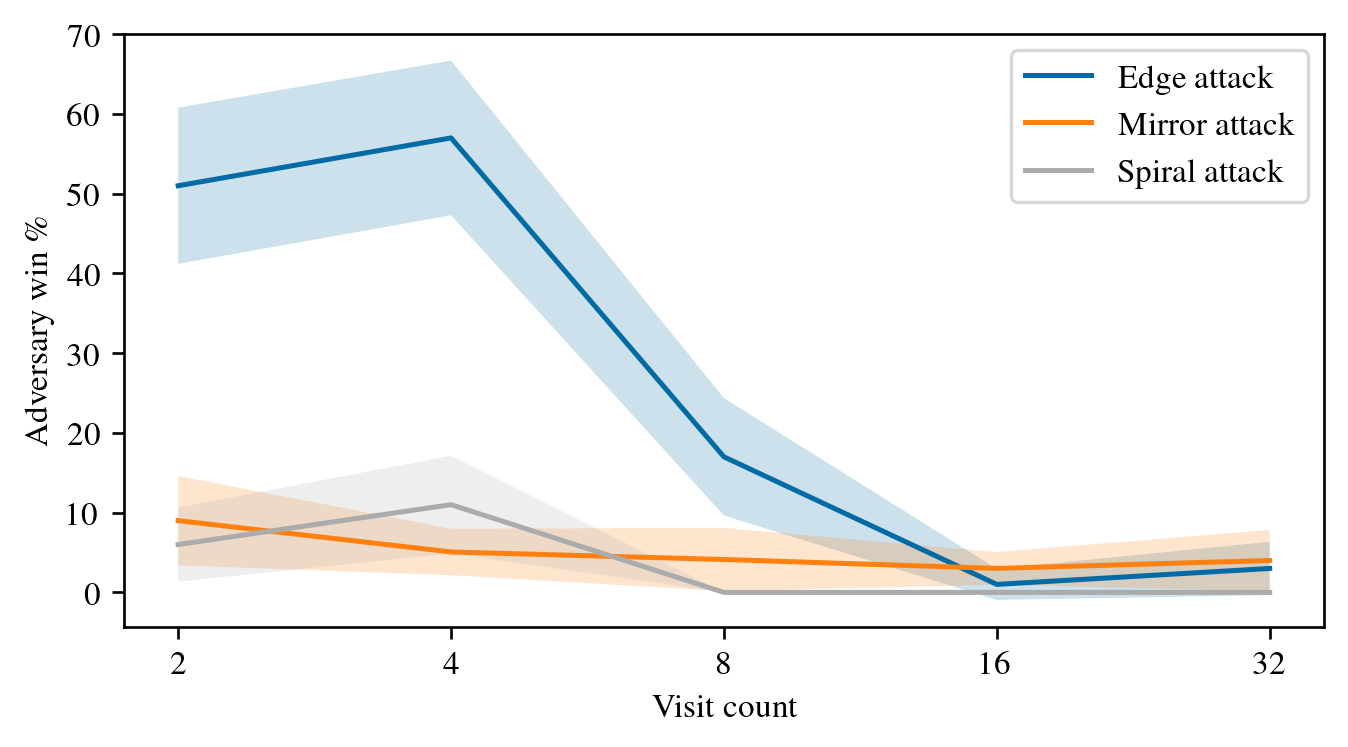

In [5]:
fig, ax = plt.subplots(1, 1)
ax.set_xlabel("Visit count")
ax.set_xscale("log", base=2)
ax.set_ylabel("Adversary win \%")

ax.set_xticks(ticks=edge_x, labels=edge_x)
yticks = np.arange(0.0, 0.8, 0.1)
ax.set_yticks(ticks=yticks, labels=[f"{100 * y:.0f}" for y in yticks])
ax.plot(edge_x, edge_winrate, label="Edge attack")
ax.plot(mirror_x, mirror_winrate, label="Mirror attack")
ax.plot(spiral_x, spiral_winrate, label="Spiral attack")
ax.fill_between(
    edge_x, edge_winrate - edge_winrate_cis, edge_winrate + edge_winrate_cis, alpha=0.2
)
ax.fill_between(
    mirror_x,
    mirror_winrate - mirror_winrate_cis,
    mirror_winrate + mirror_winrate_cis,
    alpha=0.2,
)
ax.fill_between(
    spiral_x,
    spiral_winrate - spiral_winrate_cis,
    spiral_winrate + spiral_winrate_cis,
    alpha=0.2,
)
ax.legend(loc="upper right")
fig.savefig("baseline-attack-winrates.pgf", backend="pgf")